The Lorenz attractor is a set of chaotic solutions to the Lorenz system, a system of three ordinary differential equations. It is notable for demonstrating deterministic chaos, meaning its behavior is highly sensitive to initial conditions, leading to seemingly random but ultimately predictable patterns within a bounded region of phase space.

Key aspects for a Jupyter Notebook implementation:
Lorenz Equations: The core of the system is defined by these differential equations:
dx/dt = σ(y - x)
dy/dt = rx - y - xz
dz/dt = xy - bz
where σ (sigma), r (rho), and b (beta) are parameters, commonly set to σ = 10, r = 28, and b = 8/3 for chaotic behavior.

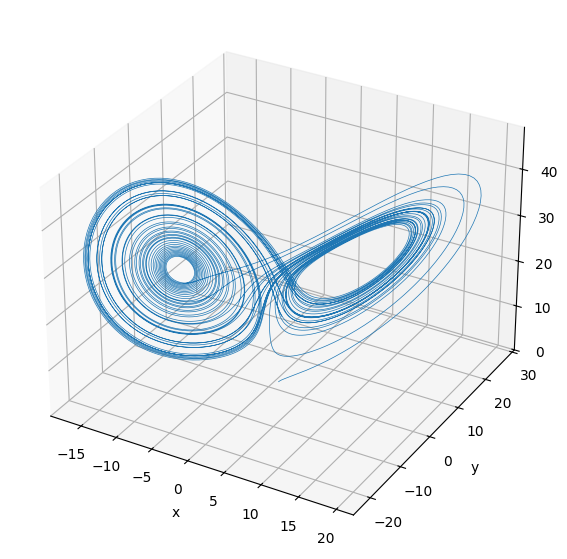

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
sigma = 10.0
rho = 28
beta = 8/3

def lorenz(t,state):
    x,y,z = state
    dxdt = sigma*(y -x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

state_0 = [1.0, 1.0, 1.0]
t_span = (0,50)
t_eval = np.linspace(*t_span, 10000)

sol = solve_ivp(lorenz, t_span, state_0, t_eval=t_eval)
x = sol.y[0]
y = sol.y[1]
z = sol.y[2]
t = sol.t

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z, lw = 0.5)
ax.set(xlabel='x', ylabel='y', zlabel='z')
plt.show()


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = np.vstack([x,y,z]).T
noisy = np.random.normal(0, 0.01, data.shape)
data_noise = data + noisy

data_noise, device

(array([[ 0.98576633,  0.99291544,  0.99772782],
        [ 0.99924184,  1.14408743,  0.98556236],
        [ 0.9997686 ,  1.26770327,  0.97749319],
        ...,
        [ 0.99808791,  1.79938593, 15.49484692],
        [ 1.02185332,  1.84824683, 15.2670527 ],
        [ 1.10537616,  1.92718661, 15.09349763]]),
 device(type='cuda', index=0))

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

tensor = torch.tensor(data_noise, dtype=torch.float32)
dataset = TensorDataset(tensor, tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [5]:
class LorenzAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
        )
    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

model = LorenzAE()

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, _ in loader:
        output, latent = model(batch_idx)
        loss = criterion(output, batch_idx)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    if epoch % 20 == 0:
        print(f"Epoch: [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch: [1/200], Loss: 101.327460
Epoch: [21/200], Loss: 0.008681
Epoch: [41/200], Loss: 0.002389
Epoch: [61/200], Loss: 0.026312
Epoch: [81/200], Loss: 0.004783
Epoch: [101/200], Loss: 0.013097
Epoch: [121/200], Loss: 0.011822
Epoch: [141/200], Loss: 0.002015
Epoch: [161/200], Loss: 0.003723
Epoch: [181/200], Loss: 0.001801


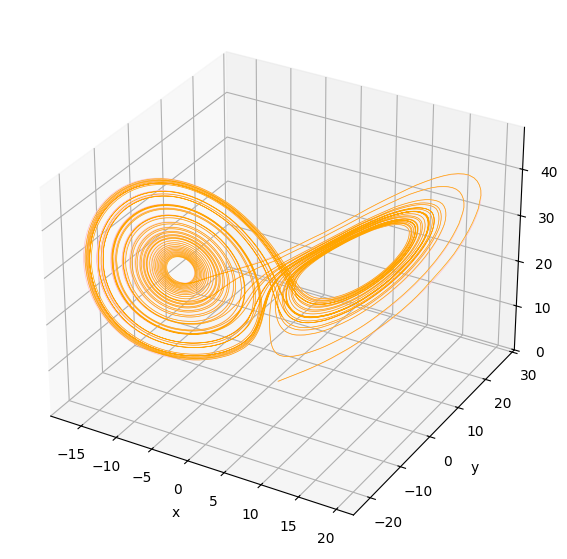

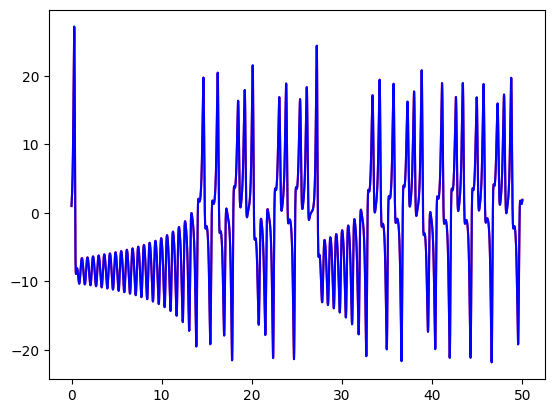

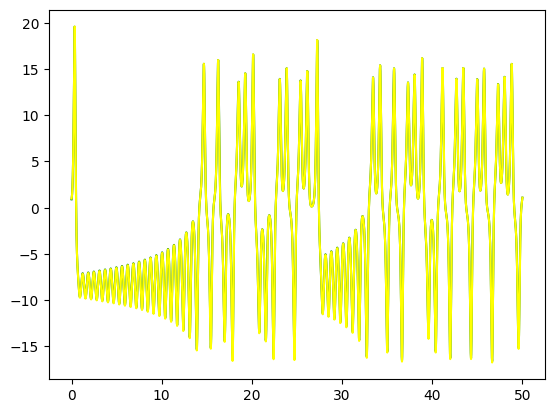

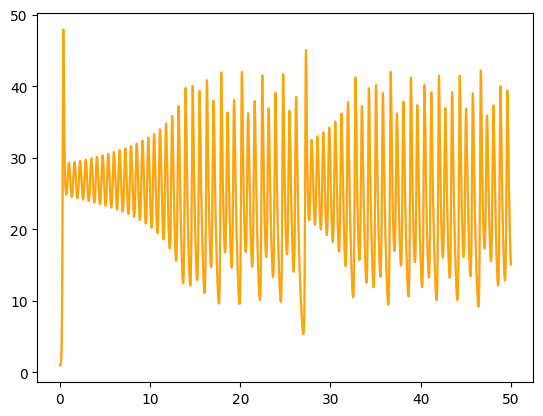

In [7]:
with torch.no_grad():
    out, latent = model(torch.tensor(data, dtype=torch.float32))

out.numpy()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z, lw = 0.5, color='pink')
ax.plot(out[:,0], out[:,1], out[:,2], color='orange', lw=0.5)
ax.set(xlabel='x', ylabel='y', zlabel='z')
plt.show()




plt.figure()
plt.plot(t, out[:,1], color='red')
plt.plot(t, y, color='blue')
plt.figure()
plt.plot(t, out[:,0], color='green')
plt.plot(t, x, color='yellow')
plt.figure()
plt.plot(t, z, color='pink')
plt.plot(t, out[:,2], color='orange')
plt.show()


In [8]:
state0_test = [2.0, -1.0, 8.0]  # different!

sol_test = solve_ivp(lorenz, t_span, state0_test, t_eval=t_eval)
x_test, y_test, z_test = sol_test.y

data_test = np.vstack([x_test, y_test, z_test]).T
tensor_test = torch.tensor(data_test, dtype=torch.float32)

In [9]:
model.eval()  # important!

with torch.no_grad():
    recon_test, latent_test = model(tensor_test)

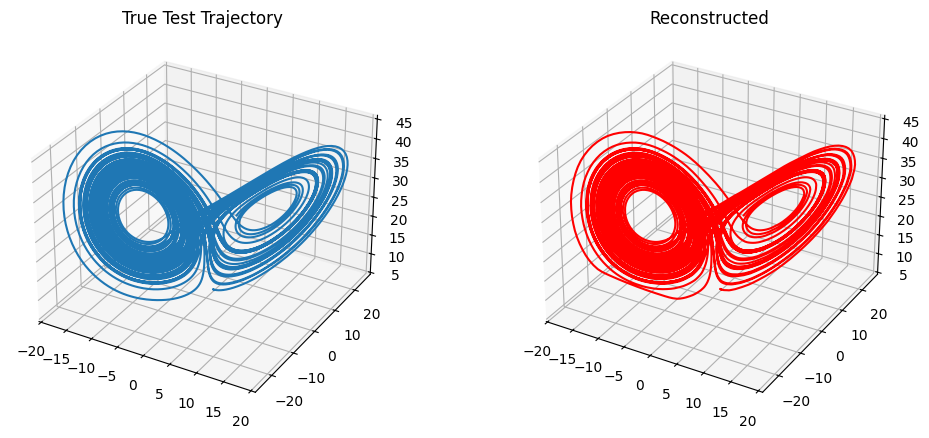

In [10]:
recon_np = recon_test.numpy()

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test, y_test, z_test, label='True')
ax1.set_title('True Test Trajectory')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(recon_np[:,0], recon_np[:,1], recon_np[:,2], label='Reconstructed', color='r')
ax2.set_title('Reconstructed')

plt.show()

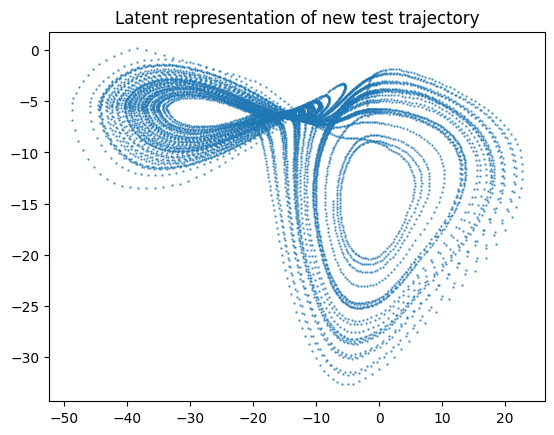

In [11]:
latent_np = latent_test.numpy()

plt.scatter(latent_np[:,0], latent_np[:,1], s=0.5, alpha=0.7)
plt.title("Latent representation of new test trajectory")
plt.show()